# 학습 목표
간단한 게임 환경에서 스스로 성장하는 DQN 에이전트를 만들어보자.


# 목차

- 강화학습과 DQN 기초
- 카트폴 게임 마스터하기


### 10.1 강화학습과 DQN 기초
주어진 환경과 상호작용하여 성장하는 머신러닝 분야를 **강화학습**이라고 한다.

앞서 배운 학습법들이 원하는 교재(데이터셋)을 외우는 주입식 학습법이라면, 강화학습은 자기 주도적 학습이라고 할 수 있다.

강화학습을 크게 **상태**, **에이전트**, **행동**, **보상** 4가지 요소로 나눌 수 있고 **환경**이라는 요소도 존재한다.

**에이전트**는 현재 **상태**의 **환경**에서 학습을 수행 혹은 의사결정을 내리는 주체이며, 의사결정에 따라 **액션**을 수행한다. 액션에 따라 환경은 또 다른 상태로 변경되며, 에이전트에게는 **보상**을 제공한다.

1. 에이전트(Agent) : 인공지능 플레이어
2. 환경(Environment) : 에이전트가 솔루션을 찾기 위한 무대
3. 행동(Action) : 에이전트가 환경 안에서 시행하는 상호작용
4. 보상(Reward) : 에이전트의 행동에 따른 점수 혹은 결과

![강화학습 구조](http://www.popit.kr/wp-content/uploads/2017/02/Screen-Shot-2017-02-28-at-4.00.34-PM-600x251.png)

> 💡 참고 링크 : [강화학습 소개](https://www.popit.kr/torch-dqn-%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5-%EC%86%8C%EA%B0%9C/)


---

### 10.2 카트폴 게임 마스터하기

강화학습 예제를 보면 항상 게임과 연관되어 있다. 어디든 적응할 수 있는 인공지능을 만들면 좋겠지만, 너무 복잡하고 가상 환경을 설계하기도 어렵기 때문에 게임이라는 **환경**을 사용한다. 

대부분의 게임은 점수나 목표가 있다. 이를 통해 보상과, 마이너스 보상을 받을 수 있다.

이번 예제에서는 카트폴이라는 환경을 구축하여 강화학습을 배울 토대를 마련해보자. 카트폴 게임에 대한 소개는 아래와 같다.

>  💡 참고 링크
> - [카트폴 게임이란](https://codetorial.net/articles/cartpole/index.html)
> - [CartPole OpenAI Wiki](https://github.com/openai/gym/wiki/CartPole-v0)

DQN(=Deep Q Network)의 주요 특징은 **기억하기** 와 **다시 보기** 이다.

순서대로 개념과 구현법을 알아보자.

구현을 위한 필수라이브러리는 아래와 같다.

- **gym** : 카트폴 등의 여러 게임 환경을 제공하는 패키지
- **deque** : double-ended queue. 양쪽 끝에서 삽입과 삭제가 모두 가능한 자료구조.
- **random, math** : 에이전트가 무작위로 행동할 확률을 구하기 위해 사용.

In [1]:
# 필수 라이브러리 import
import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

#### 10.2.1 하이퍼파라미터

- **에피소드(EPISODES)** : 총 플레이할 게임 수
- **엡실론(EPS_START, EPS_END)** : 에이전트가 무작위로 행동할 확률. 무작위로 행동하는 이유는 에이전트가 가능한 모든 행동을 경험하기 위해서이다.

시작값은 EPS_START인 90%이며, 학습이 진행되며 조금씩 감소해 EPS_END인 5%까지 내려간다.

- **앱실론 감소율(EPS_DECAY)** : EPS_START로 시작하는 엡실론의 값을 EPS_END까지 점진적으로 감소시키는 값
- **감마(GAMMA)** : 에이전트가 현재 보상을 미래 보상보다 얼마나 가치 있게 여기는지에 대한 값.

ex) 1년 후에 받을 만원과, 지금 받는 만원의 가치는 같지 않다. 1년 뒤에 받을 만원은 이자율만큼 할인해주어야하며, 할인율과 비슷한 개념이다. 감마는 할인계수(discount factor)이라고도 한다.

In [2]:
# 하이퍼 파라미터
EPISODES = 50 # 에피소드 반복 횟수
EPS_START = 0.9 # 학습 시작 시, 에이전트가 무작위로 행동할 확률
EPS_END = 0.05 # 학습 막바지에 에이전트가 무작위로 행동할 확률
EPS_DECAY = 200 # 학습 진행 시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8 # 할인계수
LR = 0.001 # 학습률
BATCH_SIZE = 64 # 배치 크기

---

#### 10.2.2 DQN 에이전트
DQN Agent 클래스는 **게임을 하기 위한 신경명**, **행동을 결정하기 위한 함수**, **각 행동의 가치를 학습하는 함수** 가 들어간다.

에이전트 신경망은 `카트 위치`, `카트 속도`, `막대기 각도`, `막대기 속도` 4가지 정보를 입력받아, 왼쪽으로 갈 때의 가치와 오른쪽으로 갈 때의 가치를 출력한다.

-> 첫 번째 신경망 입력 노드 4개, 마지막 신경망 출력 노드 2개

> 📌 찾아 보기 : '가치'라는 단어 사용 이유


---

#### 10.2.3 이전 경험 기억하기
DQN 전, 이전 신경망을 강화학습에 적용하면서 나온 몇 가지 문제가 있다.

1. 딥러닝 모델들은 보통 학습 데이터 샘플이 각각 **독립적** 이라고 가정하는데, 강화학습에서는 연속된 상태가 강한 상관관계가 있어 학습이 어렵다. -> 당연함 계속 같은 목표를 갖고 연속적인 경험을 학습하니까 초반의 몇 가지 경험 패턴에만 치중되기 때문에 **최적의 행동 패턴**을 찾기가 어렵다. 
2. 새로운 경험을 전 경험에 겹쳐 쓰면서 쉽게 잊어버린다.

-> 그래서 나온 게 **기억하기** 기능.

이전 경험들을 배열에 담아 계속 재학습시키면서 신경망이 잊지 않게 한다. 기억한 경험들은 학습을 할 때 무작위로 뽑아 경험 간의 상관관계를 줄인다.

각 경험은 **상태**, **행동**, **보상** 등을 담아야한다. -> 얘를 담은 `self.memory` 배열을 만들어보자. -> 가장 간단한 큐 자료구조 사용. 파이썬에서 deque의 `maxlen`을 사용하면 가장 오래된 요소부터 없어지기 때문에 자연스레 오래된 기억을 잊게 해준다.

그리고 `self.memory` 배열에 새로운 경험을 덧붙일 `memorize()` 함수를 만든다. 이 함수는 배열에 **현재 상태(state)**, **현재 상태에서 한 행동(action)**, **행동에 대한 보상(reward)**, **행동으로 인해 새로 생성된 상태(next_state)** 를 한 세트로 저장한다.

---

#### 10.2.4 행동하기
행동을 담당하는 `act()` 함수는 무작위로 숫자를 골라 엡실론 값보다 높으면 신경망이 학습하여 **이렇게 행동하는 게 옳다**고 생각하는 쪽으로, 낮으면 **무작위**로 행동한다.

학습 초반에는 학습이 덜 됐기 때문에 에이전트가 하는 행동에 의미를 부여하기 어렵다. -> 엡실론값 ↑ = 최대한 다양한 경험.

점차적으로 값을 낮춰가며 신경망이 결정하는 비율 높인다. 이 알고리즘을 **엡실론 그리디(epsilon-greedy)** 알고리즘이라 한다.

> 📌 참고 
>
> 파이토치 텐서의 `max()` 함수는 차원을 인수로 받아, 최댓값과 최댓값의 인덱스를 배열 텐서 형태로 반환한다.
![max() 예시](https://github.com/kjsoo-1010/pytorch_deeplearning/blob/main/10_tensor_max.png?raw=true)

---

#### 10.2.5 경험으로부터 배우기
경험을 모았으면 반복적으로 학습해야한다 = **경험 리플레이**

`learn()` : 에이전트가 경험 리플레이를 하며 학습하는 역할을 수행.

`self.memory`에 저장된 경험들의 수가 배치 크기(BATCH_SIZE)보다 커지기 전엔 return으로 학습을 패스하고, 경험이 충분히 쌓이면 `self.memory` 큐에서 무작위로 배치 크기만큼 경험들을 가져온다.

각각의 경험은 **상태**, **행동**, **행동에 따른 보상**, **다음 상태**를 담고 있으며 모두 리스트 형태이므로 `torch.cat()` 함수를 사용해 하나의 텐서로 만들어준다.


에이전트가 어떻게 하면 발전된 행동을 할까?

= 현재 상태에서 각 행동의 가치(Q)를 더 잘 예측해야함 (현재 상태를 잘 알아야 발전을 함)

-> 현재 상태(state)를 신경망에 통과시켜 왼/오로 가는 행동에 대한 가치 계산

-> `gather()` 함수로 현 상태에서 했던 행동의 가치들을 `current_q`에 담음.

-> 최대 미래 가치 생각해서 `max_next_q`에 담고, 보상과 할인률 적용한 미래 가치 더해서 예상 미래 가치를 `expected_q`에 담는다.



> 📌 왜 미래에 들어올 보상의 가치를 생각해야하지?
>
> : 그러나, 여기에는 한 가지 고려해야 하는 점이 있습니다. 바로 보상을 얻기 위해서는, 어느 정도의 "특별하지 않은", 즉 보상이 0인 행동들이 꼭 필요하다는 것이죠 — 예를 들어 코인을 얻기 위해서는, 코인이 있는 곳으로 걸어가야 합니다. 하지만 그냥 걷는 것에 대해서는 보상이 주어지지 않죠. 이러한 특징 때문에, Agent는 어떤 행동이 실제로 보상을 발생시켰는지에 대한 연결고리를 찾아서 "지연된 보상"을 잘 얻을 수 있도록 학습하는 것이 중요합니다.
>
> [출처](https://jeinalog.tistory.com/20) 

In [3]:
class DQNAgent:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
        
        # 최적화 함수 : Adam
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0 # 학습을 반복할 때마다 증가하는 변수

        # 상태, 행동, 보상 등을 담은 각 경험들
        # deque 를 써서 자연스레 오래된 기억 잊게함.
        self.memory = deque(maxlen=10000) 

        
    ### self.memory 에 새로운 경험 넣어줄 함수.
    # (현재 상태, 현재 상태에서 한 행동, 행동에 대한 보상, 행동으로 인해 새로 생성된 상태) 한 세트로 저장.
    def memorize(self, state, action, reward, next_state):
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])))
    
    ### 행동하기
    # 엡실론 값 받아서 학습시킨 대로 할 확률, 무작위로 할 확률 정함.
    def act(self, state):
        # EPS_START, EPS_END 따로 있는 이유 : 초반에는 학습 덜 돼서 행동에 의미x
        # 초반엔 하고 싶은거 다해 -> 학습 됐으면 배운대로 하자 => 엡실론 그리디 알고리즘
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if random.random() > eps_threshold:
            return self.model(state).data.max(1)[1].view(1, 1)
        else:
            return torch.LongTensor([[random.randrange(2)]])
    
    ### 경험 수집 완료 했으면 반복적으로 학습해야함. -> 경험 리플레이
    def learn(self):
        if len(self.memory) < BATCH_SIZE: # 충분한 경험 안쌓였으면 학습 패스
            return
        
        # 경험 쌓이면 경험(self.memory)에서 무작위로 경험 가져오기
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states = zip(*batch)
        
        # 상태, 행동, 보상, 다음 상태 각각 나눠주기
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        
        ### 에이전트가 어떻게 하면 발전된 행동(=성장)할까?
        # 현재 상태에서 어떤 행동이 어떤 가치를 가지는지 잘 예측해야함.
        # -> 현재 상태 신경망에 통과시켜 행동에 대한 가치 계산 -> current_q 에 담음
        current_q = self.model(states).gather(1, actions) 
        # 미래 상태 신경망에 통과시켜 행동에 대한 '미래' 최대 가치 계산 -> max_next_q 
        max_next_q = self.model(next_states).detach().max(1)[0]
        # 미래 가치는 현재가 아니기 때문에 할인율을 적용해야한다.
        # 적용한 것과 보상을 더해서 할인된 미래 가치 -> expected_q 에 저장.
        expected_q = rewards + (GAMMA * max_next_q)
        
        # 학습은 현재 에이전트가 생각하는 행동의 가치가
        # 할인된 미래 가치를 따라가도록 진행된다.
        # -> 손실 함수로 오차 계산 후 역전파 -> 신경망 학습
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


#### 10.2.6 학습 시작하기

에이전트는 게임이 끝날 때까지 행동하는 것을 멈추지 않는다.

매 턴마다
1. 현재 게임 상태(`state`)를 텐서로 만들고 에이전트 행동 함수(`act()`)의 입력으로 사용.
2. 상태(`state`)를 받은 에이전트는 엡실론 그리디 알고리즘에 따라 행동(`action`) 출력
3. `action` 변수는 파이토치 텐서이기 때문에 `item()`으로 숫자 추출하여 `step()
`에 넣어주면 에이전트의 행동에 따른 (다음 상태(`next_state`), 보상(`reward`), 종료 여부(`done`)) 가 출력된다.

In [4]:
# 게임 환경 생성
# 여기에 에이전트의 행동 입력하면 행동에 따른 다음 상태와 게임 종료 여부 출력
env = gym.make("CartPole-v0")

# 학습 실행
agent = DQNAgent() # agent 인스턴스화
score_history = [] # 학습 진행 기록

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [5]:
for e in range(1, EPISODES + 1):
    state = env.reset() # 게임 시작할 때마다 초기화된 상태(state) 불러오기
    steps = 0
    
    # 게임 끝날 때까지 계속 진행
    while True:
        env.render() # 게임 진행될 때마다 게임 화면 띄우는 함수
        state = torch.FloatTensor([state])
        action = agent.act(state) # 에이전트가 한 행동
        next_state, reward, done, _ = env.step(action.item()) # 행동에 따른 결과들

        ### 행동 결과에 따라
        # 막대 넘어져 게임 끝 => 보상 = -1
        # 이 경험을 기억(memorize()) 해서 학습 진행
        # 학습이 진행될수록 폴대가 넘어지지 않고 게임이 끝나지 않은 방향으로 진행됨.
        if done:  # 게임이 끝날 시
            reward = -1
        
        agent.memorize(state, action, reward, next_state) # 경험 기억
        agent.learn() # 학습 진행
        
        state = next_state # 다음 상태로 넘어가기
        steps += 1
        
        if done:
            print(f"에피소드: {e} 점수: {steps}")
            score_history.append(steps)
            break

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3012\2433214599.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([state])


에피소드: 1 점수: 11
에피소드: 2 점수: 16
에피소드: 3 점수: 14
에피소드: 4 점수: 37
에피소드: 5 점수: 23
에피소드: 6 점수: 9
에피소드: 7 점수: 11
에피소드: 8 점수: 11
에피소드: 9 점수: 21
에피소드: 10 점수: 9
에피소드: 11 점수: 14
에피소드: 12 점수: 16
에피소드: 13 점수: 11
에피소드: 14 점수: 11
에피소드: 15 점수: 11
에피소드: 16 점수: 17
에피소드: 17 점수: 15
에피소드: 18 점수: 12
에피소드: 19 점수: 9
에피소드: 20 점수: 11
에피소드: 21 점수: 13
에피소드: 22 점수: 10
에피소드: 23 점수: 9
에피소드: 24 점수: 8
에피소드: 25 점수: 14
에피소드: 26 점수: 41
에피소드: 27 점수: 13
에피소드: 28 점수: 29
에피소드: 29 점수: 20
에피소드: 30 점수: 32
에피소드: 31 점수: 86
에피소드: 32 점수: 54
에피소드: 33 점수: 125
에피소드: 34 점수: 200
에피소드: 35 점수: 116
에피소드: 36 점수: 123
에피소드: 37 점수: 141
에피소드: 38 점수: 153
에피소드: 39 점수: 177
에피소드: 40 점수: 195
에피소드: 41 점수: 183
에피소드: 42 점수: 200
에피소드: 43 점수: 200
에피소드: 44 점수: 189
에피소드: 45 점수: 200
에피소드: 46 점수: 200
에피소드: 47 점수: 200
에피소드: 48 점수: 200
에피소드: 49 점수: 186
에피소드: 50 점수: 200


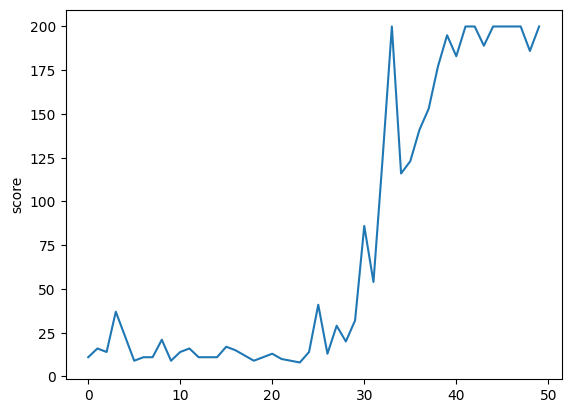

In [6]:
# 시각화
plt.plot(score_history)
plt.ylabel('score')
plt.show()